In [1]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [2]:
# from google.colab import files
# uploaded = files.upload()

# 1. GPT2 Architecture

## 1.1

- Let's load:
  1. `MultiHeadAttention` class
  2. `LayerNorm` class
  3. `GELU` class
  4. `FeedForward` class
  5. `TransformerBlock` class
  6. `GPT2Model` class

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import tiktoken


class MultiHeadAttention(nn.Module):
    def __init__(self,
                 input_embedding_dim,
                 output_embedding_dim,
                 context_length,
                 dropout,
                 num_heads,
                 qkv_bias=False):
        super().__init__()
        assert (output_embedding_dim % num_heads == 0), \
            "output_embedding_dim must be divisible by num_heads"

        self.output_embedding_dim = output_embedding_dim
        self.num_heads = num_heads
        self.head_dim = output_embedding_dim // num_heads
        self.W_query = nn.Linear(input_embedding_dim, output_embedding_dim,
                                 bias=qkv_bias)
        self.W_key = nn.Linear(input_embedding_dim, output_embedding_dim,
                               bias=qkv_bias)
        self.W_value = nn.Linear(input_embedding_dim, output_embedding_dim,
                                 bias=qkv_bias)
        self.output_projection = nn.Linear(output_embedding_dim,
                                           output_embedding_dim)  # to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1))

    def forward(self, inputs):
        batch, num_tokens, input_embedding_dim = inputs.shape

        # qkv shapes : (batch, num_tokens, output_embedding_dim)
        keys = self.W_key(inputs)
        values = self.W_value(inputs)
        queries = self.W_query(inputs)

        # qkv shapes : (batch, num_tokens, num_heads, head_dim)
        keys = keys.view(batch, num_tokens, self.num_heads, self.head_dim)
        values = values.view(batch, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(batch, num_tokens, self.num_heads, self.head_dim)

        # qkv shapes : (batch, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        queries = queries.transpose(1, 2)

        # compute attention scores for each head
        attention_scores = queries @ keys.transpose(3, 2)
        attention_scores.masked_fill_(
            self.mask.bool()[:num_tokens, :num_tokens], - torch.inf)

        # compute attention weights + dropout
        masked_attention_weight = torch.softmax(
            attention_scores / (keys.shape[-1] ** 0.5),
            dim=-1)
        masked_attention_dropout_weight = self.dropout(masked_attention_weight)

        # compute context vectors
        # shape : (batch, num_tokens, num_heads, head_dim)
        context_vector = (masked_attention_dropout_weight @ values).transpose(1, 2)

        # combine heads, where self.d_out = self.num_heads * self.head_dim
        # shape : (batch, num_tokens, output_embedding_dim)
        context_vector = context_vector.contiguous().view(
            batch, num_tokens, self.output_embedding_dim)

        # linear projection (optional)
        context_vector = self.output_projection(context_vector)

        return context_vector


class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.epsilon = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1,
                    unbiased=False,  # Bessel's correction (n-1)
                    keepdim=True)
        norm_x = (x - mean) / torch.sqrt(var + self.epsilon)
        return self.scale * norm_x + self.shift


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(config["emb_dim"],  # 768
                      4 * config["emb_dim"]),  # 3072
            GELU(),  # 3072
            nn.Linear(4 * config["emb_dim"],  # 3072
                      config["emb_dim"])  # 768
        )

    def forward(self, x):
        return self.layers(x)


class TransformerBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(input_embedding_dim=config["emb_dim"],
                                            output_embedding_dim=config["emb_dim"],
                                            context_length=config["context_length"],
                                            dropout=config["drop_rate"],
                                            num_heads=config["n_heads"],
                                            qkv_bias=config["qkv_bias"])
        self.feed_forward = FeedForward(config)
        self.layer_norm1 = LayerNorm(config["emb_dim"])
        self.layer_norm2 = LayerNorm(config["emb_dim"])
        self.drop_skip = nn.Dropout(config["drop_rate"])

    def forward(self, x):
        # skip connection for attention block
        shortcut = x
        x = self.layer_norm1(x)
        x = self.attention(x)  # shape: [batch_size, num_tokens, emb_size]
        x = self.drop_skip(x)
        x = shortcut + x  # skip connection

        # skip connection for feed forward block
        shortcut = x
        x = self.layer_norm2(x)
        x = self.feed_forward(x)
        x = self.drop_skip(x)
        x = shortcut + x  # skip connection

        return x


class GPT2Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_emb = nn.Embedding(config["vocab_size"],
                                      config["emb_dim"])
        self.position_emb = nn.Embedding(config["context_length"],
                                         config["emb_dim"])
        self.drop_emb = nn.Dropout(config["drop_rate"])

        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(config) for _ in range(config["n_layers"])])

        self.final_norm = LayerNorm(config["emb_dim"])

        self.out_head = nn.Linear(config["emb_dim"],
                                  config["vocab_size"],
                                  bias=False)

    def forward(self, input_token):
        batch_size, sequence_length = input_token.shape
        token_embeds = self.token_emb(input_token)
        position_embeds = self.position_emb(
            torch.arange(sequence_length,
                         device=input_token.device))
        embeds = token_embeds + position_embeds
        x = self.drop_emb(embeds)
        x = self.transformer_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits




class GPT2DatasetV1(Dataset):
  def __init__(self,
               text,
               tokenizer,
               context_length, # length of each input vector
               stride # chunk the text into overlapping sequence of context_length
               ):
    self.input_id_vectors = []
    self.target_id_vectors = []

    # tokenize the entire text
    token_list = tokenizer.encode(text)

    # append input and target vectors
    for i in range(0, len(token_list) - context_length, stride):
      input_vector = token_list[i:i+context_length]
      target_vector = token_list[i+1:i+context_length+1]
      self.input_id_vectors.append(torch.tensor(input_vector))
      self.target_id_vectors.append(torch.tensor(target_vector))

  # get the number of input vectors
  def __len__(self):
    return len(self.input_id_vectors)

  # return the (input vector, target vector) pair
  def __getitem__(self, id):
    return self.input_id_vectors[id], self.target_id_vectors[id]



def create_dataloader_V1(text,
                 batch_size=4,
                 context_length=256,
                 stride=128,
                 shuffle=True, # shuffle dataset
                 drop_last=True, # drop last batch if it not equal required size
                 num_workers=0 # number of CPU processes for preprocessing
                 ):

  tokenizer = tiktoken.get_encoding("gpt2")

  dataset = GPT2DatasetV1(text=text,
                          tokenizer=tokenizer,
                          context_length=context_length,
                          stride=stride)

  dataloader = DataLoader(dataset=dataset,
                          batch_size=batch_size,
                          shuffle=shuffle,
                          drop_last=drop_last,
                          num_workers=num_workers)

  return dataloader

## 1.2 Training and Evaluation Functions

- Let's load:
  1. `train_model_simple`: without warmup rate, cosine decay, gradient clipping
  2. `train_model`
  3. `evaluate_model`

In [4]:
import torch
import math




def train_model_simple(model,
                       train_loader,
                       val_loader,
                       optimizer,
                       device,
                       num_epochs,
                       eval_freq,
                       eval_iter,
                       start_context,
                       tokenizer):

  # initialize lists to track losses and tokens seen
  train_losses = []
  val_losses = []
  track_tokens_seen = []
  token_seen = 0
  global_step = -1

  # main training loop - iterate over training epochs
  for epoch in range(num_epochs):
    # set model to training mode
    model.train()

    # iterate over batches in each training epoch
    for input_batch, target_batch in train_loader:
      # reset loss gradients from previous batch iteration
      optimizer.zero_grad()

      # calculate loss on current batch
      loss = calc_loss_batch(input_batch,
                             target_batch,
                             model,
                             device)

      # backward pass to calculate loss gradients
      loss.backward()

      # update model weights using loss gradients
      optimizer.step()
      token_seen += input_batch.numel()
      global_step += 1

      # optional evaluation step
      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(model,
                                              train_loader,
                                              val_loader,
                                              device,
                                              eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(token_seen)
        # print training and evaluation set loss
        print(f"Ep {epoch+1} (Step {global_step:06d}): "
              f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

    # generative sample text for visual inspection
    generate_and_print_sample(model,
                              tokenizer,
                              device,
                              start_context)

  return train_losses, val_losses, track_tokens_seen






ORIG_BOOK_VERSION = False
def train_model(model,
                train_loader,
                val_loader,
                optimizer,
                device,
                n_epochs,
                eval_freq,
                eval_iter,
                start_context,
                tokenizer,
                warmup_steps,
                initial_lr=3e-05,
                min_lr=1e-6):

  train_losses, val_losses = [], []
  track_tokens_seen, track_lrs = [], []

  token_seen = 0
  global_step = -1

  # retrieve the maximum/peak learning rate from the optimizer
  peak_lr = optimizer.param_groups[0]["lr"]

  # calculate the total number of iterations in the training process
  total_training_steps = len(train_loader) * n_epochs

  # calculate the learning rate increment during the warmup phase
  lr_increment = (peak_lr - initial_lr) / warmup_steps

  for epoch in range(n_epochs):
    model.train()
    for input_batch, target_batch in train_loader:
      optimizer.zero_grad()
      global_step += 1

      # adjust the learning rate based on the current phase (warmup or cosine)
      if global_step < warmup_steps:
        lr = initial_lr + global_step * lr_increment
      else:
        # cosine annealing after warmup
        progress = ((global_step - warmup_steps) /
                    (total_training_steps - warmup_steps))
        lr = (min_lr +
         (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress)))

      # apply the calculated learning rate to the optimizer
      for param_group in optimizer.param_groups:
        param_group["lr"] = lr
      track_lrs.append(lr) # store the current learning rate

      # calculate and backpropagate the loss
      loss = calc_loss_batch(input_batch,
                             target_batch,
                             model,
                             device)
      loss.backward()

      # apply gradient clipping after the warmup phase to avoid exploding gradients
      if ORIG_BOOK_VERSION:
        if global_step > warmup_steps:
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      else:
        # the book originally used global_step > warmup_steps, which led to a skipped clipping step after warmup
        if global_step >= warmup_steps:
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

      optimizer.step()
      token_seen += input_batch.numel()

      # periodically evaluate the model on the training and validation sets
      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(model,
                                              train_loader,
                                              val_loader,
                                              device,
                                              eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(token_seen)
        # print the current losses
        print(f"Ep {epoch+1} (Iter {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}")

    # generate and print a sample from the model to monitor progess
    generate_and_print_sample(
        model=model,
        tokenizer=tokenizer,
        device=device,
        start_context=start_context
    )

  return train_losses, val_losses, track_tokens_seen, track_lrs







def evaluate_model(model,
                    train_loader,
                    val_loader,
                    device,
                    eval_iter):
  # set model to evaluation mode
  model.eval()
  with torch.no_grad():
    # calculate loss
    train_loss = calc_loss_loader(train_loader,
                                  model,
                                  device,
                                  num_batches=eval_iter)
    val_loss = calc_loss_loader(val_loader,
                                model,
                                device,
                                num_batches=eval_iter)

  # set model back to training mode
  model.train()
  return train_loss, val_loss







############################### utils functions #############################
############################### utils functions #############################
############################### utils functions #############################
############################### utils functions #############################
############################### utils functions #############################


def calc_loss_batch(input_batch,
                    target_batch,
                    model,
                    device):
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)

  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1),
                                           target_batch.flatten())
  return loss


def calc_loss_loader(dataloader,
                     model,
                     device,
                     num_batches=None):
  total_loss = 0.
  if len(dataloader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(dataloader)
  else:
    # reduce the number of batches to match the total number of batches in the data loader
    # if num_batches exceeds the number of batches in the data loader
    num_batches = min(num_batches, len(dataloader))
  for i, (input_batch, target_batch) in enumerate(dataloader):
    if i < num_batches:
      loss = calc_loss_batch(input_batch,
                             target_batch,
                             model,
                             device)
      total_loss += loss.item()
    else:
      break
  return total_loss / num_batches



def generate_and_print_sample(model,
                              tokenizer,
                              device,
                              start_context):
  # set model to evaluation mode
  model.eval()
  context_size = model.position_emb.weight.shape[0]
  encoded = text_to_token_ids(start_context, tokenizer).to(device)
  with torch.no_grad():
    token_ids = generate_text_simple(model=model,
                                     input_batch=encoded,
                                     max_new_tokens=50,
                                     context_size=context_size)
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " ")) # compact print format
  # set model back to training mode
  model.train()




def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

  # turn the list of token IDs into tensor with batch dimension
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(encoded_tensor, tokenizer):
  # turn tensor without batch dimension to list
  token_ids = encoded_tensor.squeeze(0).tolist()
  text = tokenizer.decode(token_ids)
  return text




def generate_text_simple(model,
                         input_batch,  # [batch, num_tokens]
                         max_new_tokens,  # numbers of new tokens to be predicted
                         context_size):
    for _ in range(max_new_tokens):
        # crop current context if it exceeds the supported context_size
        crop_input_batch = input_batch[:, -context_size:]

        # predict next token
        with torch.no_grad():
            logits = model(crop_input_batch)

        # consider only logits of the last token
        logits = logits[:, -1, :]  # (batch, n_tokens, vocab_size) -> (batch, vocab_size)
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)
        predicted_tokens = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)
        # update input_batch (append predicted tokens to the sequences)
        input_batch = torch.cat([input_batch, predicted_tokens], dim=-1)  # [batch, num_tokens+1]

    return input_batch



def generate_text(model,
                  input_batch,
                  max_new_tokens,
                  context_size,
                  temperature=0.0,
                  top_k=None,
                  eos_id=None):
  for _ in range(max_new_tokens):
    # crop current context if it exceeds the supported context_size
    crop_input_batch = input_batch[:, -context_size:]

    # predict next token
    with torch.no_grad():
      logits = model(crop_input_batch)

    # consider only logits of the last token
    logits = logits[:, -1, :] # (batch, n_tokens, vocab_size) -> (batch, vocab_size)

    # NEW: filter logits with top_k sampling
    if top_k is not None:
      # keep only top_k values
      top_logits, _ = torch.topk(logits, top_k)
      min_val = top_logits[:, -1] # min value among the top_k values
      # all values other than top_k values will be set to -inf
      logits = torch.where(logits < min_val,
                           torch.tensor(-torch.inf).to(logits.device),
                           logits)

    # NEW: temperature scaling
    if temperature > 0.0:
      logits = logits / temperature

      probas = torch.softmax(logits, dim=-1) # (batch, vocab_size)
      predicted_tokens = torch.multinomial(probas, num_samples=1) # (batch, 1)

    else: # same as before
      #probas = torch.softmax(logits, dim=-1) # (batch, vocab_size)
      predicted_tokens = torch.argmax(logits, dim=-1, keepdim=True) # (batch, 1)

    if predicted_tokens == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

    # update input_batch (append predicted tokens to the sequences)
    input_batch = torch.cat([input_batch, predicted_tokens], dim=1) # [batch, num_tokens+1]

  return input_batch
############################### utils functions #############################
############################### utils functions #############################
############################### utils functions #############################
############################### utils functions #############################
############################### utils functions #############################

## 1.3 LoRA layer

In [5]:
import math
import torch

class LoRALayer(torch.nn.Module):
  def __init__(self, in_dim, out_dim, rank, alpha):
    super().__init__()
    self.A = torch.nn.Parameter(torch.empty(in_dim, rank))
    # Kaiming/He uniform initialization, similar to standard weight initialization
    torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5))
    self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
    self.alpha = alpha

  def forward(self, x):
    x = self.alpha * (x @ self.A @ self.B)
    return x


class LinearLayerWithLoRA(torch.nn.Module):
  def __init__(self, linear, rank, alpha):
    super().__init__()
    self.linear = linear
    self.lora = LoRALayer(linear.in_features,
                          linear.out_features,
                          rank,
                          alpha)

  def forward(self, x):
    return self.linear(x) + self.lora(x)



def replace_linear_with_lora(model, rank, alpha):
  for name, module in model.named_children():
    if isinstance(module, torch.nn.Linear):
      print(f"Replacing {name} with LinearLayerWithLoRA")
      setattr(model, name, LinearLayerWithLoRA(module, rank, alpha))
    else:
      # recursively apply the same function to child modules
      replace_linear_with_lora(module, rank, alpha)

## 1.3 Dataset
- We'll use `war-and-peace.txt` dataset

# 2. Gradio app

## 2.1 Training

In [6]:
# setup
file_path = "war_and_peace.txt"
with open(file_path, "r", encoding="utf-8") as f:
  text = f.read()

total_characters = len(text)
bpe_tokenizer = tiktoken.get_encoding("gpt2")
total_tokens = len(bpe_tokenizer.encode(text))
print(f"total characters: {total_characters}")
print(f"total tokens: {total_tokens}")

total characters: 3227520
total tokens: 853923


In [7]:
# train-test split
train_ratio = 0.90
split_id = int(train_ratio * len(text))
train_text = text[:split_id]
val_text = text[split_id:]

In [8]:
# create dataloaders
torch.manual_seed(211)


train_dataloader = create_dataloader_V1(text=train_text,
                                        batch_size=8,
                                        context_length=BASE_CONFIG["context_length"],
                                        stride=BASE_CONFIG['context_length'],
                                        shuffle=True,
                                        drop_last=True,
                                        num_workers=0)

val_dataloader = create_dataloader_V1(text=val_text,
                                      batch_size=8,
                                      context_length=BASE_CONFIG["context_length"],
                                      stride=BASE_CONFIG['context_length'],
                                      shuffle=False,
                                      drop_last=False,
                                      num_workers=0)

In [9]:
# Sanity check

if total_tokens * (train_ratio) < BASE_CONFIG["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < BASE_CONFIG["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [10]:
# --- Clean up GPU memory ---
import gc
# del train_loss, val_loss  # if you don't need them anymore
#del train_dataloader, val_dataloader  # optional, if not reused
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [11]:
model = GPT2Model(BASE_CONFIG)

In [12]:
# Let's compute initial losses!!!
import time
compute_loss_start_time = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
  train_loss = calc_loss_loader(train_dataloader,
                                model,
                                device)
  val_loss = calc_loss_loader(val_dataloader,
                              model,
                              device)

print(f"train loss: {train_loss:.4f}")
print(f"validation loss: {val_loss:.4f}")


compute_loss_end_time = time.time()
runtime_in_seconds = compute_loss_end_time - compute_loss_start_time
# format as minutes and seconds
minutes, seconds = divmod(runtime_in_seconds, 60)
print(f"compute_loss runtime: {int(minutes)} min {seconds:.2f} sec")

train loss: 10.9779
validation loss: 10.9860
compute_loss runtime: 0 min 20.55 sec


In [13]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")

for param in model.parameters():
    param.requires_grad = False

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

Total trainable parameters before: 163,037,184
Total trainable parameters after: 0


In [14]:
replace_linear_with_lora(model, rank=16, alpha=16)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable LoRA parameters: {total_params:,}")

Replacing W_query with LinearLayerWithLoRA
Replacing W_key with LinearLayerWithLoRA
Replacing W_value with LinearLayerWithLoRA
Replacing output_projection with LinearLayerWithLoRA
Replacing 0 with LinearLayerWithLoRA
Replacing 2 with LinearLayerWithLoRA
Replacing W_query with LinearLayerWithLoRA
Replacing W_key with LinearLayerWithLoRA
Replacing W_value with LinearLayerWithLoRA
Replacing output_projection with LinearLayerWithLoRA
Replacing 0 with LinearLayerWithLoRA
Replacing 2 with LinearLayerWithLoRA
Replacing W_query with LinearLayerWithLoRA
Replacing W_key with LinearLayerWithLoRA
Replacing W_value with LinearLayerWithLoRA
Replacing output_projection with LinearLayerWithLoRA
Replacing 0 with LinearLayerWithLoRA
Replacing 2 with LinearLayerWithLoRA
Replacing W_query with LinearLayerWithLoRA
Replacing W_key with LinearLayerWithLoRA
Replacing W_value with LinearLayerWithLoRA
Replacing output_projection with LinearLayerWithLoRA
Replacing 0 with LinearLayerWithLoRA
Replacing 2 with Line

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPT2Model(
  (token_emb): Embedding(50257, 768)
  (position_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): LinearLayerWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_key): LinearLayerWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_value): LinearLayerWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (output_projection): LinearLayerWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): LinearLaye

In [16]:
num_epochs = 10
initial_lr = 0.0001
peak_lr = 3e-5


total_steps = len(train_dataloader) * num_epochs
warmup_steps = int(0.2 * total_steps) # 20% warmup
print(warmup_steps)

188


In [17]:
import time
training_start_time = time.time()

torch.manual_seed(211)

optimizer = torch.optim.AdamW(model.parameters(),
                              lr=peak_lr,
                              weight_decay=0.01)

train_losses, val_losses, tokens_seen, track_lrs = train_model(model=model,
                                                    train_loader=train_dataloader,
                                                    val_loader=val_dataloader,
                                                    optimizer=optimizer,
                                                    device=device,
                                                    n_epochs=num_epochs,
                                                    eval_freq=5,
                                                    eval_iter=5,
                                                    start_context="In the midst of winter, I found",
                                                    tokenizer=bpe_tokenizer,
                                                    warmup_steps=warmup_steps,
                                                    initial_lr=1e-5,
                                                    min_lr=1e-5)


training_end_time = time.time()
runtime_in_seconds = training_end_time - training_start_time
# format as minutes and seconds
minutes, seconds = divmod(runtime_in_seconds, 60)
print(f"device: {device}")
print(f"training runtime: {int(minutes)} min {seconds:.2f} sec")

Ep 1 (Iter 000000): Train loss 10.912, Val loss 10.916
Ep 1 (Iter 000005): Train loss 10.532, Val loss 10.537
Ep 1 (Iter 000010): Train loss 9.872, Val loss 9.903
Ep 1 (Iter 000015): Train loss 9.156, Val loss 9.183
Ep 1 (Iter 000020): Train loss 8.557, Val loss 8.578
Ep 1 (Iter 000025): Train loss 7.958, Val loss 7.950
Ep 1 (Iter 000030): Train loss 7.379, Val loss 7.364
Ep 1 (Iter 000035): Train loss 7.032, Val loss 6.949
Ep 1 (Iter 000040): Train loss 6.710, Val loss 6.701
Ep 1 (Iter 000045): Train loss 6.526, Val loss 6.562
Ep 1 (Iter 000050): Train loss 6.411, Val loss 6.514
Ep 1 (Iter 000055): Train loss 6.445, Val loss 6.499
Ep 1 (Iter 000060): Train loss 6.541, Val loss 6.480
Ep 1 (Iter 000065): Train loss 6.447, Val loss 6.459
Ep 1 (Iter 000070): Train loss 6.374, Val loss 6.440
Ep 1 (Iter 000075): Train loss 6.249, Val loss 6.413
Ep 1 (Iter 000080): Train loss 6.327, Val loss 6.376
Ep 1 (Iter 000085): Train loss 6.361, Val loss 6.345
Ep 1 (Iter 000090): Train loss 6.209, Val 

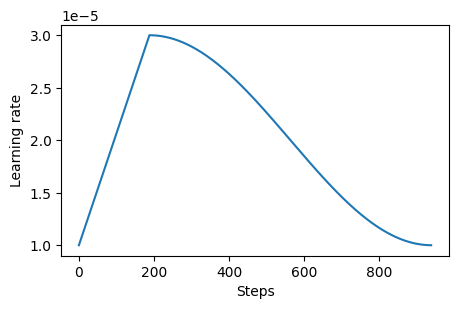

In [18]:
import matplotlib.pyplot as plt


plt.figure(figsize=(5, 3))
plt.plot(range(len(track_lrs)), track_lrs)
plt.ylabel("Learning rate")
plt.xlabel("Steps")
plt.show()

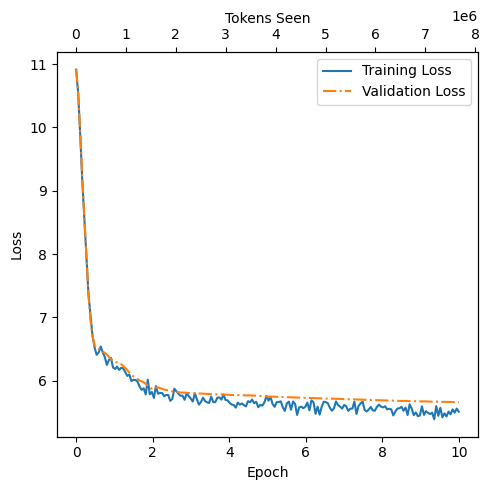

In [19]:
# Let's plot a loss graph:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt


def plot_losses(epoch_seen,
                tokens_seen,
                train_losses,
                val_losses):
  """Plot training and validation loss in xkcd style."""

  fig, ax1 = plt.subplots(figsize=(5, 5))

  # plot training and validation loss against epochs
  ax1.plot(epoch_seen, train_losses, label="Training Loss")
  ax1.plot(epoch_seen, val_losses, linestyle="-.", label="Validation Loss")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Loss")
  ax1.legend(loc="upper right")
  ax1.xaxis.set_major_locator(MaxNLocator(integer=True)) # only show integer labels on x-axis

  # create a second x-axis for token seen
  ax2 = ax1.twiny() # create a second x-axis that shares the same y-axis
  ax2.plot(tokens_seen, train_losses, alpha=0) # invisible plot for aligning ticks
  ax2.set_xlabel("Tokens Seen")

  fig.tight_layout() # asjust layput to make room
  plt.savefig("stable_training_with_lora_loss_plot.png")
  plt.show()


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [20]:
model.to("cpu")
model.eval()

bpe_tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(model=model,
                                 input_batch=text_to_token_ids("In the midst of winter, I found",
                                                               bpe_tokenizer),
                                 max_new_tokens=20,
                                 context_size=BASE_CONFIG["context_length"]
                                 )


print("output text: \n", token_ids_to_text(token_ids, bpe_tokenizer))

output text: 
 In the midst of winter, I found







the room, and the









In [21]:
# save model state_dict
torch.save(model.state_dict(), "stable_training_with_lora_gpt2.pth")

In [22]:
# load model state_dict

bpe_tokenizer = tiktoken.get_encoding("gpt2")

model = GPT2Model(BASE_CONFIG)
replace_linear_with_lora(model, rank=16, alpha=16)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("stable_training_with_lora_gpt2.pth", map_location=device, weights_only=True))
model = model.to(device)
model.eval()

Replacing W_query with LinearLayerWithLoRA
Replacing W_key with LinearLayerWithLoRA
Replacing W_value with LinearLayerWithLoRA
Replacing output_projection with LinearLayerWithLoRA
Replacing 0 with LinearLayerWithLoRA
Replacing 2 with LinearLayerWithLoRA
Replacing W_query with LinearLayerWithLoRA
Replacing W_key with LinearLayerWithLoRA
Replacing W_value with LinearLayerWithLoRA
Replacing output_projection with LinearLayerWithLoRA
Replacing 0 with LinearLayerWithLoRA
Replacing 2 with LinearLayerWithLoRA
Replacing W_query with LinearLayerWithLoRA
Replacing W_key with LinearLayerWithLoRA
Replacing W_value with LinearLayerWithLoRA
Replacing output_projection with LinearLayerWithLoRA
Replacing 0 with LinearLayerWithLoRA
Replacing 2 with LinearLayerWithLoRA
Replacing W_query with LinearLayerWithLoRA
Replacing W_key with LinearLayerWithLoRA
Replacing W_value with LinearLayerWithLoRA
Replacing output_projection with LinearLayerWithLoRA
Replacing 0 with LinearLayerWithLoRA
Replacing 2 with Line

GPT2Model(
  (token_emb): Embedding(50257, 768)
  (position_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): LinearLayerWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_key): LinearLayerWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_value): LinearLayerWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (output_projection): LinearLayerWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): LinearLaye

## 2.2 Gradio

In [23]:
# !pip install pdf2image

In [24]:
# from pdf2image import convert_from_path

# # convert page 1 of your PDF to a PIL image
# pages = convert_from_path("stable_training_with_lora_loss_plot.pdf", dpi=200)
# diagram_img = pages[0]
# diagram_img.save("stable_training_with_lora_loss_plot.png", "PNG")

In [27]:
import time
import torch

def generate_answer(input_prompt,
                    #model,
                    max_new_tokens,
                    top_k,
                    temperature,
                    ):

  # start the timer
  start_time = time.time()

  torch.manual_seed(211)

  model.eval()

  token_ids = generate_text(
      model=model,
      input_batch=text_to_token_ids(input_prompt, bpe_tokenizer).to(device),
      max_new_tokens=max_new_tokens,
      context_size=BASE_CONFIG["context_length"],
      top_k=top_k,
      temperature=temperature
  )

  # Calculate the prediction time
  pred_time = round(time.time() - start_time)

  # print("Output text:\n", token_ids_to_text(token_ids, bpe_tokenizer))
  return token_ids_to_text(token_ids, bpe_tokenizer), pred_time

In [32]:
import gradio as gr

# Create title, description and article strings
title = "GPT2 From Scratch"
description = "Pretrained GPT2 (124M) from scratch with LoRA."
article = "Learning LLM from scratch"


# Create the Gradio demo
demo = gr.Interface(fn=generate_answer, # mapping function from input to output
                    inputs=[
                        gr.Textbox(label="Input Text"),
                        gr.Slider(minimum=0, maximum=500, step=1, value=50, label="Choose number of generating tokens"),
                        gr.Slider(minimum=0, maximum=50, step=1, value=10, label="Choose top k"),
                        gr.Slider(minimum=0.0, maximum=5.0, step=0.1, value=1.5, label="Choose temperature"),
                        ],
                    outputs=[
                        gr.Textbox(label="Result"),
                        gr.Number(label="Time Taken (s)"),
                        gr.Image(label="Training Loss"),
                        ],
                    #examples=example_list,
                    title=title,
                    description=description,
                    article=article,
                    )

# Launch the demo!
demo.launch(debug=True, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://abb9b3728f18ab0d30.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://abb9b3728f18ab0d30.gradio.live
